In [20]:
import torch
from torch.optim import Adam
import numpy as np
import matplotlib.pylab as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["figure.facecolor"] = (1, 1, 1, 1)# default (1,1,1,0) make it solid here


In [4]:
from scipy.stats import ortho_group
def SO2mat(angle_deg):
    """Generate SO(2) group rotation matrix based on angle"""
    angle = angle_deg / 180 * np.pi
    mat = np.array([[np.cos(angle), np.sin(angle)],
           [-np.sin(angle), np.cos(angle)]])
    return mat

basis = SO2mat(60)
basisT = SO2mat(-60)

In [139]:
def QuadFunc(XX,YY,Q):
    qf = XX**2 * Q[0,0] + 2 * XX*YY * Q[0,1] + YY**2 * Q[1,1]
    return qf

def vis_QuadFunc(xticks, yticks, Q, addfig=False):
    XX, YY = np.meshgrid(xticks, yticks)
    qf = QuadFunc(XX, YY, Q)
    if not addfig: plt.figure(figsize=[8,8])
    plt.contour(XX,YY,qf,70)
    plt.axis("image")
    plt.title("Quadratic Function")
    if not addfig: plt.show()
    return XX,YY,qf

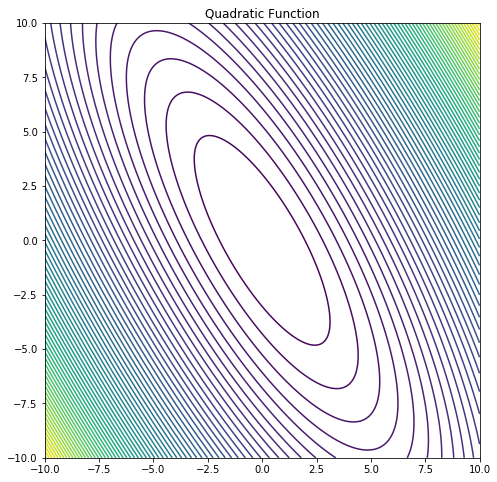

In [140]:
basis = torch.tensor(SO2mat(60))
Lambda = torch.diag(torch.tensor([1.0,10.0])).double()
Q = basis @ Lambda @ basis.T
XX,YY,qf = vis_QuadFunc(np.arange(-10,10.1,0.1), np.arange(-10,10.1,0.1), Q.numpy())

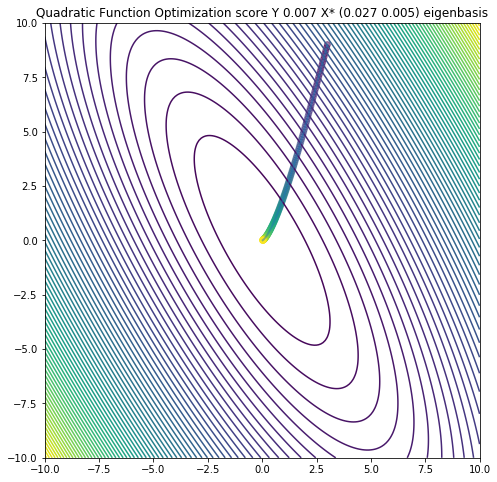

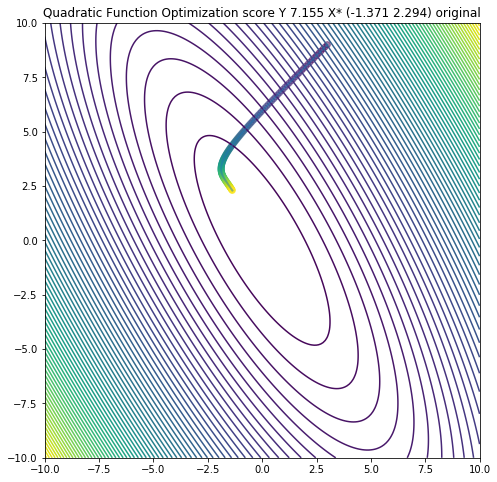

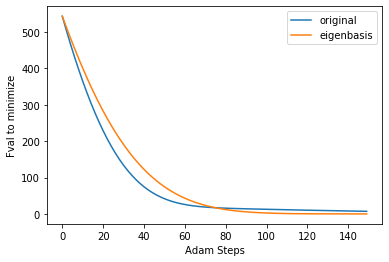

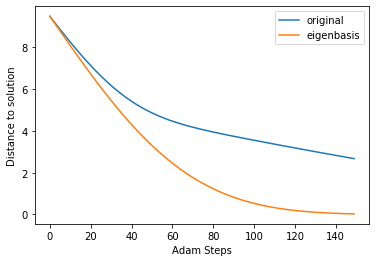

In [132]:
def demo_Adam_optim(Q, basis, x0=[8, -4], nsteps=150, lr=0.1, eigenbasis=True):
    z = torch.tensor(x0).squeeze().double()
    if eigenbasis:
        rz = (basis.T @ z.unsqueeze(1)).squeeze()
        rz.requires_grad_(True)
        optimizer = Adam([rz],lr=lr)
    else:
        z.requires_grad_(True)
        optimizer = Adam([z],lr=lr)
    traj  = []
    ytraj = []
    for step in range(nsteps):
        if eigenbasis:
            z = (basis @ rz.unsqueeze(1)).squeeze()
        optimizer.zero_grad()
        y = z.unsqueeze(0)@Q@z.unsqueeze(1)
        y.backward()
        traj.append(z.detach().clone())
        ytraj.append(y.detach().clone())
        optimizer.step()

    traj = torch.stack(traj)
    ytraj = torch.stack(ytraj)
    fig = plt.figure(figsize=[8,8])
    plt.plot(traj[:,0],traj[:,1],linewidth=2,alpha=0.5)
    plt.scatter(traj[:,0],traj[:,1],c=np.arange(0,traj.shape[0]),alpha=0.5)
    vis_QuadFunc(np.arange(-10,10.1,0.1), np.arange(-10,10.1,0.1), Q.numpy(), addfig=True)
    # plt.contour(XX,YY,qf,70)
    plt.axis("image")
    plt.title("Quadratic Function Optimization score Y %.3f X* (%.3f %.3f) %s"%(ytraj[-1], traj[-1,0], traj[-1,1],\
                                                                "eigenbasis" if eigenbasis else "original"))
    plt.show()
    return traj, ytraj, fig

def optim_traj_cmp(traj_col, ytraj_col, labels):
    fig1 = plt.figure()
    for ytraj, label in zip(ytraj_col, labels):
        plt.plot(ytraj.squeeze(),label=label)
    plt.ylabel("Fval to minimize")
    plt.xlabel("Adam Steps")
    plt.legend()
    plt.show()
    fig2 = plt.figure()
    for traj, label in zip(traj_col, labels):
        plt.plot(traj.norm(dim=1),label=label)
    plt.ylabel("Distance to solution")
    plt.xlabel("Adam Steps")
    plt.legend()
    plt.show()
    return fig1,fig2

basis = torch.tensor(SO2mat(60))
Lambda = torch.diag(torch.tensor([1.0,10.0])).double()
Q = basis @ Lambda @ basis.T
x0 = [3, 9]
traj_r, ytraj_r, fig_r = demo_Adam_optim(Q, basis, x0=x0, nsteps=150, lr=0.1, eigenbasis=True);
traj, ytraj, fig = demo_Adam_optim(Q, basis, x0=x0, nsteps=150, lr=0.1, eigenbasis=False);
cmpfg1, cmpfg2 = optim_traj_cmp([traj, traj_r], [ytraj, ytraj_r], ["original", "eigenbasis"]);
fig_r.savefig("AdamSchematic_rotated.png")
fig_r.savefig("AdamSchematic_rotated.pdf")
fig.savefig("AdamSchematic_orig.png")
fig.savefig("AdamSchematic_orig.pdf")
cmpfg1.savefig("ScoreCmp_RotOrig.pdf")
cmpfg2.savefig("DistCmp_RotOrig.pdf")

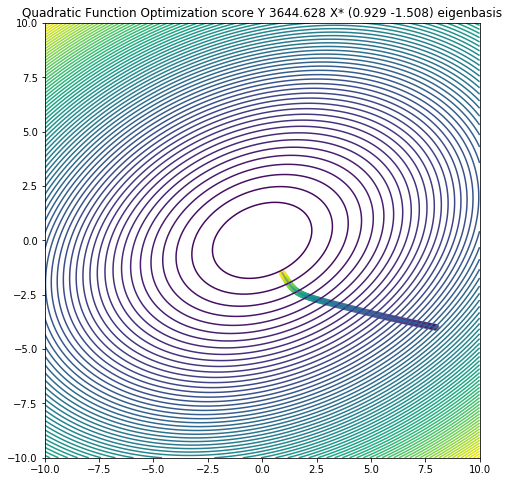

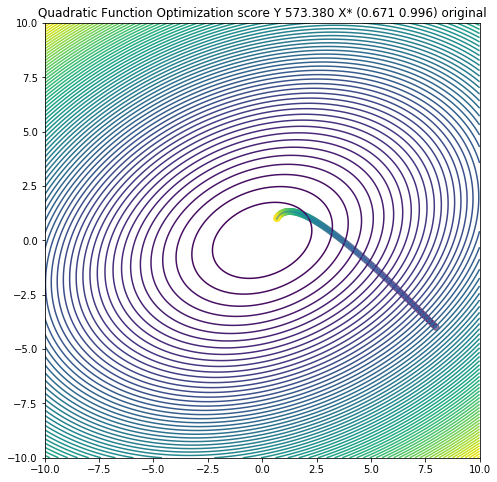

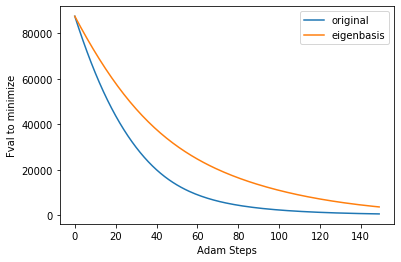

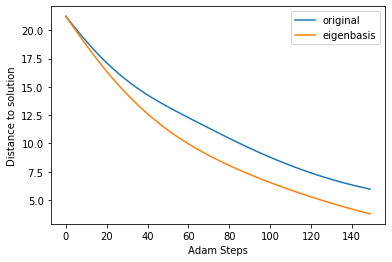

In [147]:
spectra = [0.01,0.1,3,22, 40, 54,115, 255, 520]
basis = torch.tensor(ortho_group.rvs(len(spectra))).double()
Lambda = torch.diag(torch.tensor(spectra)).double()
Q = basis @ Lambda @ basis.T
x0 = [8, -4, 5, 7, 9, -8, 4, 10, 6]
lr = 0.1
traj_r, ytraj_r, fig_r = demo_Adam_optim(Q, basis, x0=x0, nsteps=150, lr=lr, eigenbasis=True)
traj, ytraj, fig = demo_Adam_optim(Q, basis, x0=x0, nsteps=150, lr=lr, eigenbasis=False)
cmpfg1, cmpfg2 = optim_traj_cmp([traj, traj_r], [ytraj, ytraj_r], ["original", "eigenbasis"]);

In [109]:
z = torch.tensor(x0).squeeze().double()
rz = (basis.T @ z.unsqueeze(1)).squeeze()
basis @ rz.unsqueeze(1).squeeze()

tensor([ 8.0000, -4.0000,  5.0000,  4.0000,  9.0000, -8.0000],
       dtype=torch.float64)

In [ ]:
nsteps = 150
z = torch.tensor([8, -4]).double()
z.requires_grad_(True)
optimizer = Adam([z],lr=0.1)
traj  = []
ytraj = []
for step in range(nsteps):
    optimizer.zero_grad()
    y = z.unsqueeze(0)@Q@z.unsqueeze(1)
    y.backward()
    traj.append(z.detach().clone())
    ytraj.append(y.detach().clone())
    optimizer.step()

traj = torch.stack(traj)
ytraj = torch.stack(ytraj)
#%
plt.figure(figsize=[10,10])
plt.plot(traj[:,0],traj[:,1],'o--',linewidth=2,alpha=0.5)
plt.contour(XX,YY,qf,70)
plt.axis("image")
plt.title("Quadratic Function Final score Y %.3f X* (%.3f %.3f)"%(ytraj[-1], traj[-1,0], traj[-1,1]))
plt.show()

In [ ]:
nsteps = 150
z = torch.tensor([8, -4]).double()
rz = (basis.T @ z.unsqueeze(1)).squeeze()
rz.requires_grad_(True)
optimizer = Adam([rz],lr=0.1)
traj  = []
ytraj = []
for step in range(nsteps):
    z = (basis @ rz.unsqueeze(1)).squeeze()
    optimizer.zero_grad()
    y = z.unsqueeze(0)@Q@z.unsqueeze(1)
    y.backward()
    traj.append(z.detach().clone())
    ytraj.append(y.detach().clone())
    optimizer.step()

traj = torch.stack(traj)
ytraj = torch.stack(ytraj)
#%
plt.figure(figsize=[10,10])
plt.plot(traj[:,0],traj[:,1],'o--',linewidth=2,alpha=0.5)
plt.contour(XX,YY,qf,70)
plt.axis("image")
plt.title("Quadratic Function Final score Y %.3f X* (%.3f %.3f)"%(ytraj[-1], traj[-1,0], traj[-1,1]))
plt.show()